# Visión por Computadora I - 2025 - B3 - Trabajo práctico 3
**Inteligencia Artificial - CEIA - FIUBA**

## Autores

- **Mendoza Dante**.
- **Vasquez Jorge**.
- **Viñas Gustavo**.

# 💻 TP3 - Parte 1.

(4 puntos) Obtener una detección del logo en cada imagen sin falsos positivos.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from imutils.object_detection import non_max_suppression

In [2]:
# Lista de imágenes a procesar (incluimos coca_multi.png)
image_files = [
    "images/coca_logo_1.png",
    "images/coca_logo_2.png",
    "images/coca_retro_1.png",
    "images/coca_retro_2.png",
    "images/COCA-COLA-LOGO.jpg",
    "images/logo_1.png",
    "images/coca_multi.png"
]

# Cargamos el template
template = cv2.imread("template/pattern.png", cv2.IMREAD_GRAYSCALE)

# Se utilizó TM_CCORR_NORMED ya que fue el que mejor resultados obtuvo
# Con TM_SQDIFF_NORMED solo se pudo reconocer el template en 1 imagen
# TM_CCOEFF_NORMED reconoció el template en todas las imágenes, pero con score menor
method = cv2.TM_CCORR_NORMED

In [3]:
def detect(image_file: str, template_scale: float=1., image_scale: float=1., method: int=cv2.TM_CCORR_NORMED):
    # Aplicamos resize al template
    template_resized = cv2.resize(template, None, fx=template_scale, fy=template_scale)
    # Aplicamos Canny al template redimensionado
    template_canny = cv2.Canny(template_resized, 50, 100)
    # Recortamos del template el espacio "vacio" (ajustamos el template al contenido)
    coords = cv2.findNonZero(template_canny) # Find all non-zero points
    x, y, w, h = cv2.boundingRect(coords) # Find minimum spanning bounding box
    p = 2 # Padding alrededor del template (para probar)
    template_canny = template_canny[y-p:y+h+p, x-p:x+w+p]

    # Cargamos la imagen
    img = cv2.imread(image_file)
    # Verificamos las relación respecto al template
    scale_x = template_resized.shape[1] / img.shape[1]
    scale_y = template_resized.shape[0] / img.shape[0]
    # Valor mayor a 1 indica que el template es mas grande que la imagen en algún sentido
    scale_img = max(scale_x, scale_y)
    # Por mas que se indique por parámetro, no podemos ajustar mas allá del tamaño del template
    scale_img = max(scale_img, image_scale)
    # Reescalo si es necesario, o si es indicado por parámetro
    if (scale_img != 1):
        img = cv2.resize(img, None, fx=scale_img, fy=scale_img)
    # Convertimos a grises
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Aplicamos Canny a la imagen redimensionada
    img_canny = cv2.Canny(img_gray, 200, 300)

    # Aplicamos match template
    result = cv2.matchTemplate(img_canny, template_canny, method)
    # Encontramos los valores máximos y mínimos
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
    val = min_val if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED] else max_val
    loc = min_loc if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED] else max_loc

    return { "template_canny": template_canny, "image": img, "image_canny": img_canny, "score": val, "box_location": loc }

def plot_detection(best_result, image_file):
    # Graficamos el template
    plt.figure(figsize=(4, 3))
    plt.imshow(best_result["template_canny"], cmap="gray")
    plt.title(f"Template (scale: {best_result['template_scale']:.2f})")
    plt.show()

    tH, tW = best_result["template_canny"].shape[:2] # Dimensión final del template
    # Dibujamos el rectángulo detectado
    loc = best_result["box_location"]
    cv2.rectangle(best_result["image"], (loc[0], loc[1]), (loc[0] + tW, best_result["box_location"][1] + tH), (0, 255, 0), 2)
    # Y el valor de confianza
    cv2.putText(best_result["image"], f"{best_result['score']:.2f}", (loc[0], loc[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    # Cargamos la imagen original
    img = cv2.imread(image_file)

    # Mostramos la imagen final
    fig, axs = plt.subplots(1, 3, figsize=(10, 5), constrained_layout=True)
    axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[0].set_title("Original")
    axs[1].imshow(cv2.cvtColor(best_result["image"], cv2.COLOR_BGR2RGB))
    axs[1].set_title("Redimensionada")
    axs[2].imshow(best_result["image_canny"], cmap="gray")
    axs[2].set_title("Canny")
    fig.suptitle(f"{image_file} - Score: {best_result['score']:.3f} - Scale: {best_result['image_scale']:.1f}")
    plt.show()

def find_best(image_file, method=cv2.TM_CCORR_NORMED):
    best_score = 1 if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED] else 0
    best_result = None
    for t_scale in np.arange(0.2, 1.5, 0.01):
        for i_scale in np.arange(0.1, 1.1, 0.1):
            res = detect(image_file, template_scale=float(t_scale), image_scale=float(i_scale), method=method)
            if (method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED] and res["score"]<best_score) or \
               (method not in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED] and res["score"]>best_score):
                best_score = res["score"]
                best_result = res
                best_result["template_scale"] = t_scale
                best_result["image_scale"] = i_scale
    if (best_result is None):
        raise(Exception("No se encontró el template en la imagen"))
    return best_result

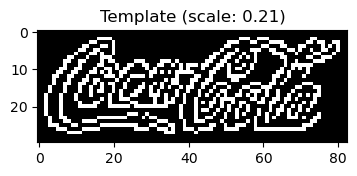

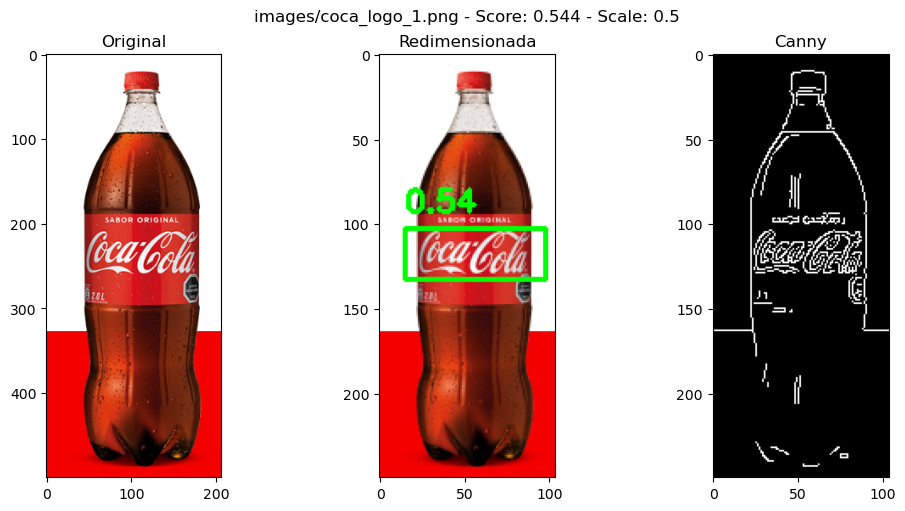

In [4]:
# Detección sobre imagen 1
image = image_files[0]
best_result = find_best(image, method=method)
plot_detection(best_result, image)

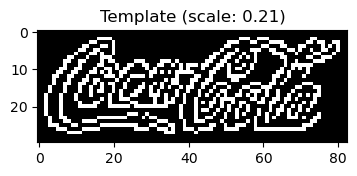

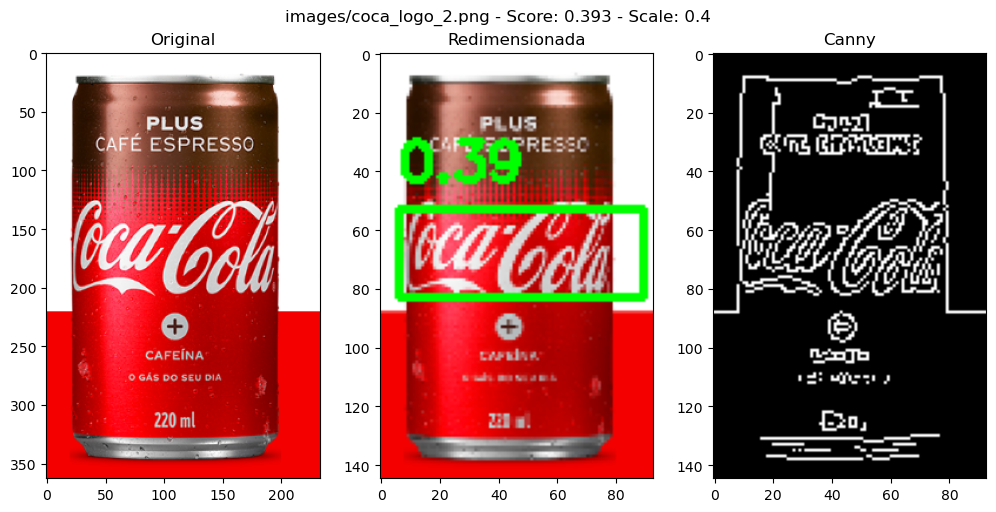

In [5]:
# Detección sobre imagen 2
image = image_files[1]
best_result = find_best(image, method=method)
plot_detection(best_result, image)

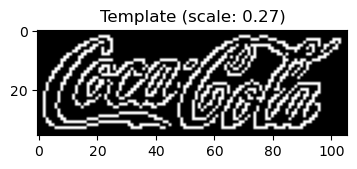

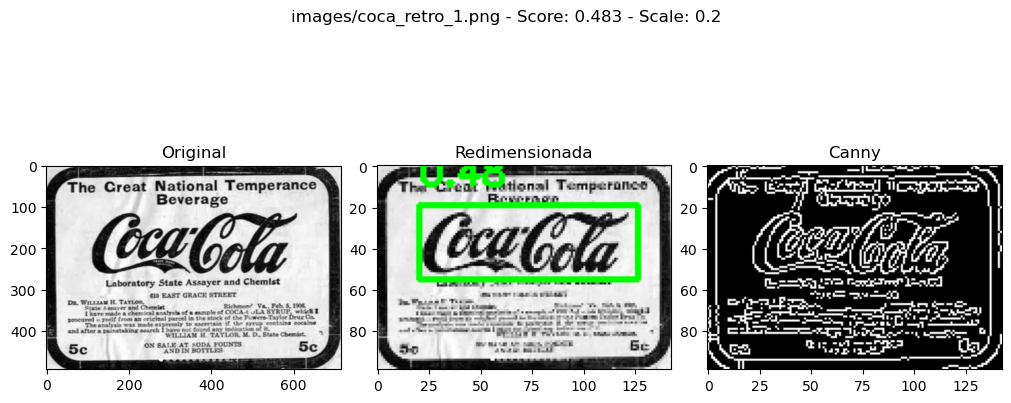

In [6]:
# Detección sobre imagen 3
image = image_files[2]
best_result = find_best(image, method=method)
plot_detection(best_result, image)

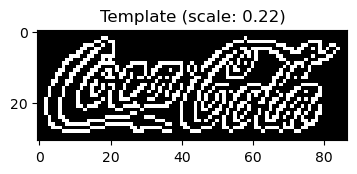

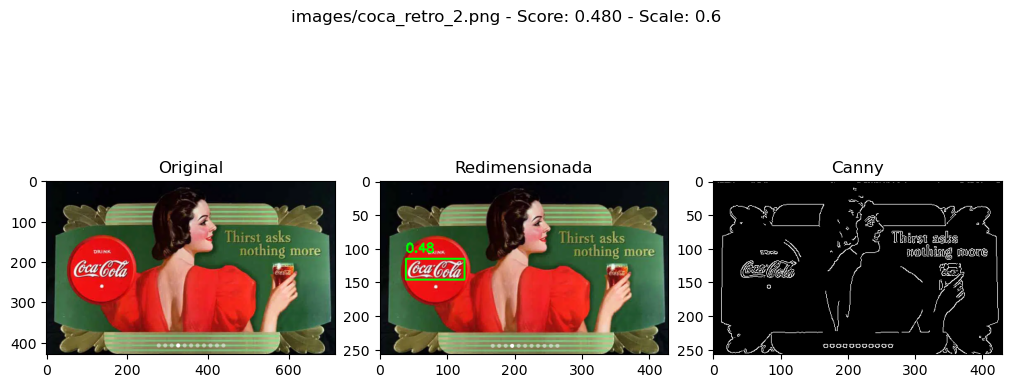

In [7]:
# Detección sobre imagen 4
image = image_files[3]
best_result = find_best(image, method=method)
plot_detection(best_result, image)

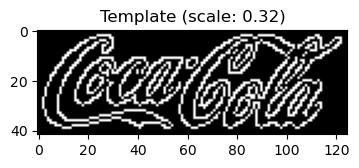

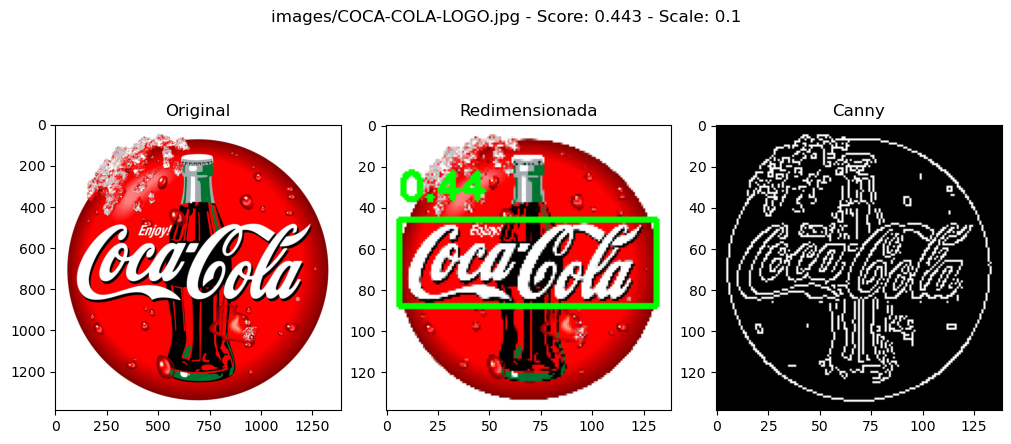

In [8]:
# Detección sobre imagen 5
image = image_files[4]
best_result = find_best(image, method=method)
plot_detection(best_result, image)

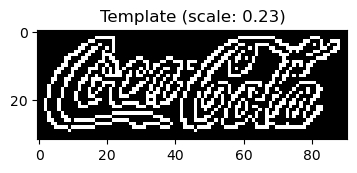

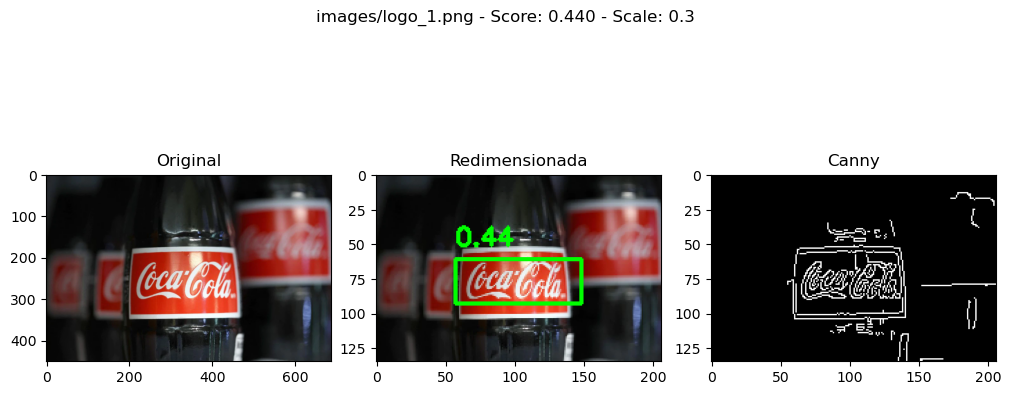

In [9]:
# Detección sobre imagen 6
image = image_files[5]
best_result = find_best(image, method=method)
plot_detection(best_result, image)

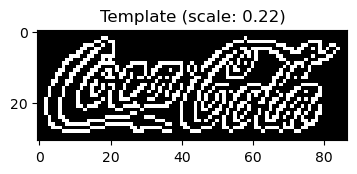

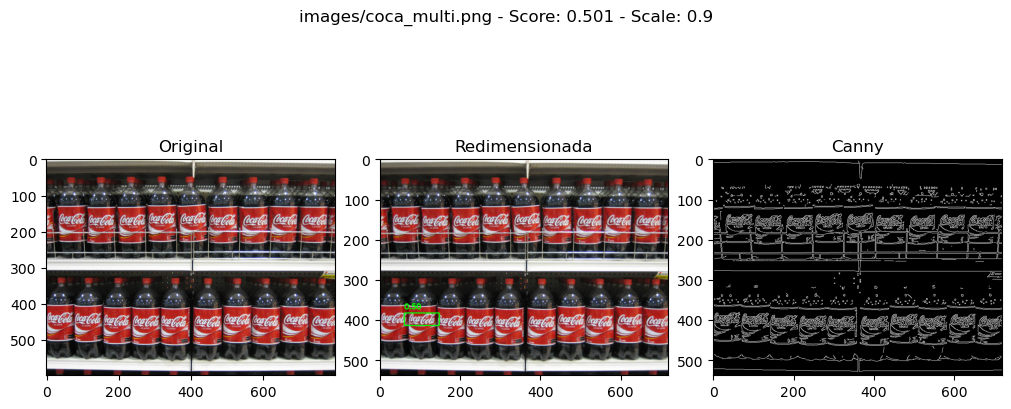

In [10]:
# Detección sobre imagen 7
image = image_files[6]
best_result = find_best(image, method=method)
plot_detection(best_result, image)

# 💻 TP3 - Parte 2.

(4 puntos) Plantear y validar un algoritmo para múltiples detecciones en la imagen coca_multi.png con el mismo témplate del ítem 1.

In [11]:
def detect_multi(template_canny, img_canny, method: int=cv2.TM_CCORR_NORMED, threshold=0.4):
    all_rects = []
    all_scores = []

    tH, tW = template_canny.shape[:2] # Dimensión final del template

    # Aplicamos match template
    result = cv2.matchTemplate(img_canny, template_canny, method)

    # Todas las detecciones sobre el threshold que definimos
    (y_coords, x_coords) = np.where(result <= threshold) if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED] else np.where(result >= threshold)

    for (x, y) in zip(x_coords, y_coords):
        all_rects.append([x, y, x + tW, y + tH])
        all_scores.append(result[y, x])

    # Aplicamos NMS
    boxes = non_max_suppression(np.array(all_rects), probs=np.array(all_scores), overlapThresh=0.3)
    return boxes

def plot_multi(best_result, boxes, image_file, method: int=cv2.TM_CCORR_NORMED):
    # Graficamos el template
    plt.figure(figsize=(4, 3))
    plt.imshow(best_result["template_canny"], cmap="gray")
    plt.title(f"Template (scale: {best_result['template_scale']:.2f})")
    plt.show()

    # Dibujamos los bounding boxes
    img_redim = best_result["image"]
    scores = []
    for (startX, startY, endX, endY) in boxes:
        roi = best_result["image_canny"][startY:endY, startX:endX]
        if roi.size == 0:
            continue
        score = np.max(cv2.matchTemplate(roi, best_result["template_canny"], method))
        scores.append(score)
        cv2.rectangle(img_redim, (startX, startY), (endX, endY), (0, 255, 0), 2)
        cv2.putText(img_redim, f"{score:.2f}", (startX, startY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    # Cargamos la imagen original
    img = cv2.imread(image_file)

    # Mostramos la imagen final
    fig, axs = plt.subplots(1, 3, figsize=(10, 5), constrained_layout=True)
    axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[0].set_title("Original")
    axs[1].imshow(cv2.cvtColor(img_redim, cv2.COLOR_BGR2RGB))
    axs[1].set_title("Redimensionada")
    axs[2].imshow(best_result["image_canny"], cmap="gray")
    axs[2].set_title("Canny")
    fig.suptitle(f"{image_file} - Detecciones: {len(boxes)} - Score (mean): {np.mean(scores):.3f} - Scale: {best_result['image_scale']:.1f}")
    plt.show()

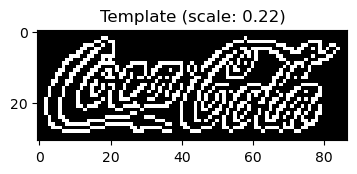

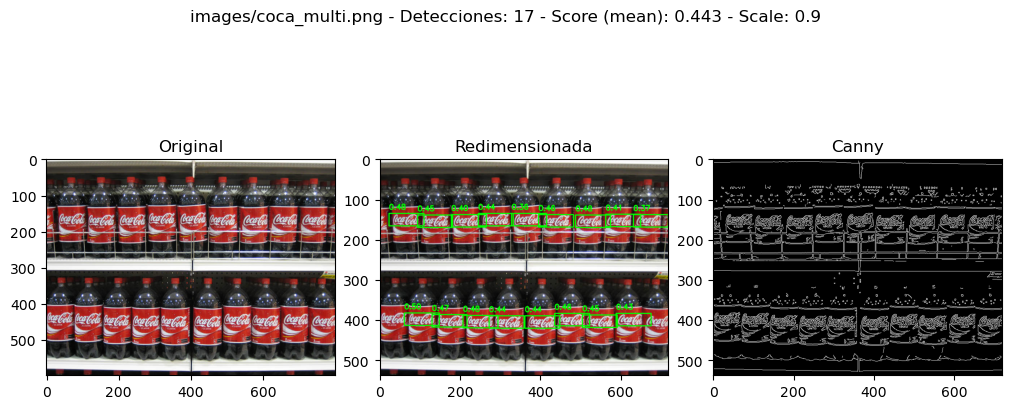

In [12]:
# Detección multiple sobre imagen 7. Usamos los resultados del punto anterior.
boxes = detect_multi(best_result["template_canny"], best_result["image_canny"], method=method, threshold=0.36)
plot_multi(best_result, boxes, image, method=method)

# 💻 TP3 - Parte 3.

(2 puntos) Generalizar el algoritmo del item 2 para todas las imágenes.

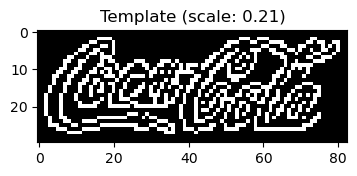

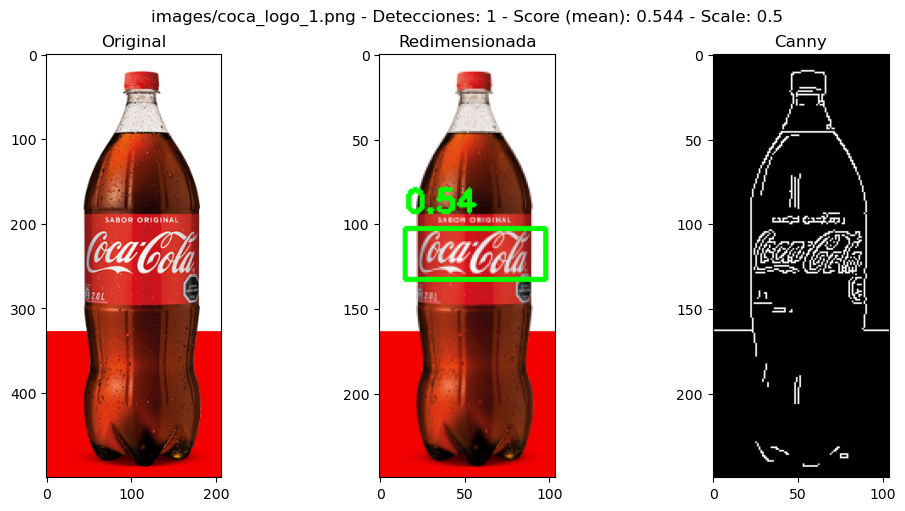

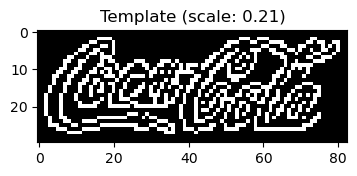

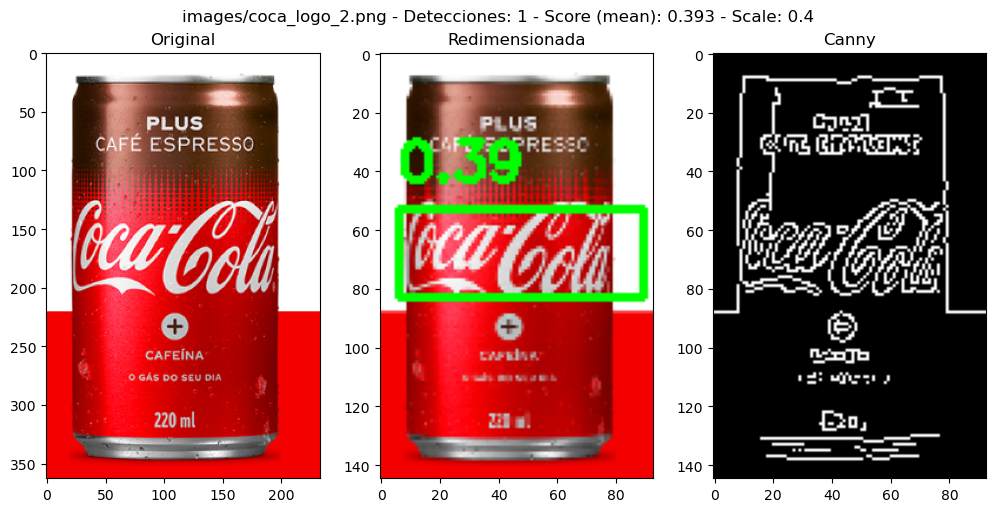

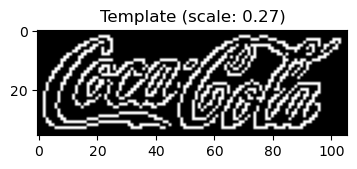

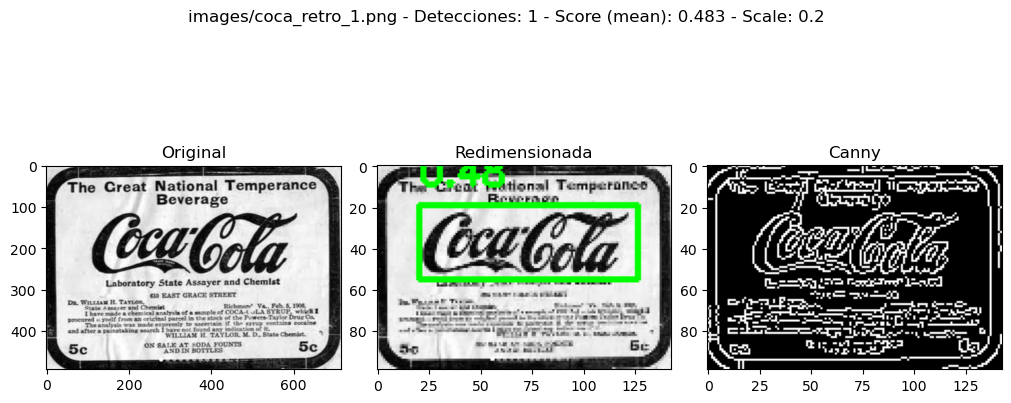

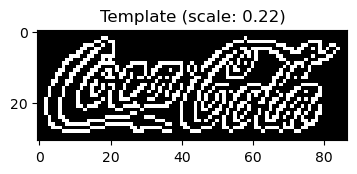

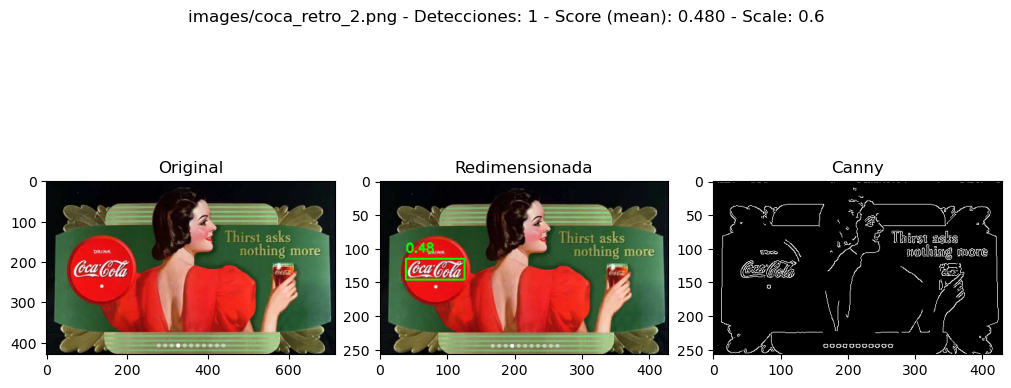

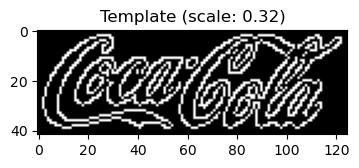

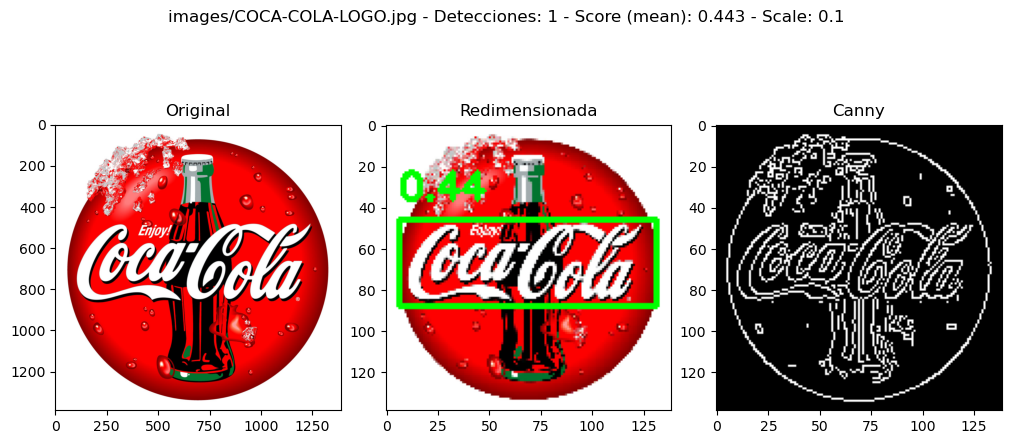

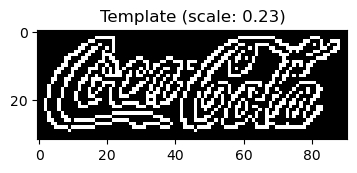

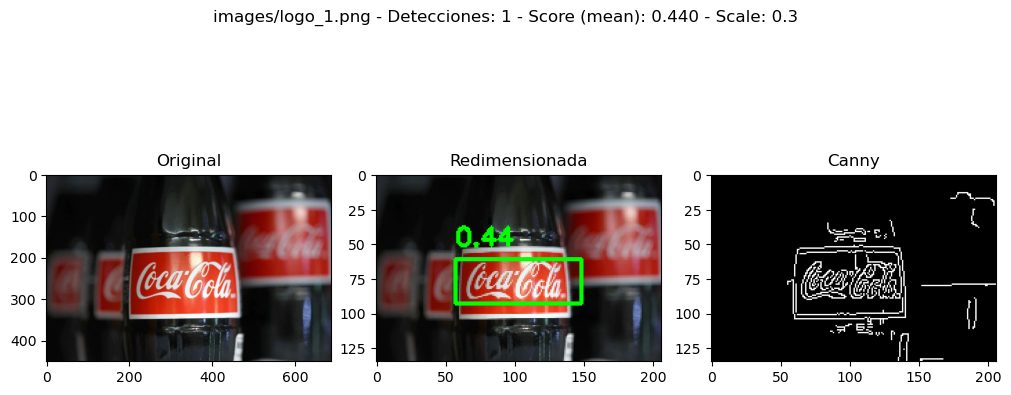

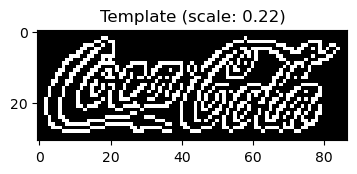

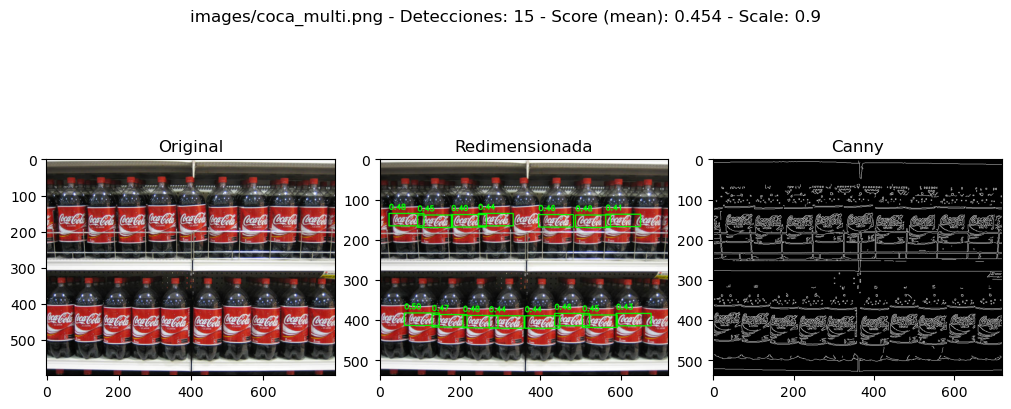

In [13]:
for image in image_files:
    best_score = find_best(image, method=method) # Buscamos la mejor detección individual
    threshold = best_score["score"] * 0.8 # Usamos como threshold el 80% del valor máximo
    # Buscamos todas las detecciones posibles
    boxes = detect_multi(best_score["template_canny"], best_score["image_canny"], method=method, threshold=threshold)
    # Graficamos el resultado
    plot_multi(best_score, boxes, image, method=method)